## Import all needed libraries for the project

In [175]:
import nltk
nltk.download(['stopwords','punkt','wordnet','averaged_perceptron_tagger'])
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from zeugma.embeddings import EmbeddingTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Afsul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Afsul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Afsul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Afsul\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Read training dataset that will be used later for training classifiers

In [203]:
df = pd.read_csv(r"D:downloadsnew\OLIDv1.0\olid-training-v1.0.tsv", sep='\t')
df

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH
13238,27429,@USER Pussy,OFF,UNT,NaN


## Prepare the environment functions starting by sample function

In [84]:
def sample(df,column, flag):
    """
    @param: df     : The data framse that will be sampled from
    @param: column : the column that will be used when sampling by counting the minority or majority classes
    @param: flag   : to indicate whether to over or under sample
    return will return a balnced data set based on the given column
    """
    domin = None
    len_domin = len(df)
    if flag:
        len_domin = 0
    df = df.dropna(subset= [column])
    for x in df[column].unique():
        if not flag: 
            if len(df[df[column] == x]) < len_domin:
                domin = x
                len_domin = len(df[df[column] == x])
        if flag: 
            if len(df[df[column] == x]) > len_domin:
                domin = x
                len_domin = len(df[df[column] == x])

    new_df = df[df[column] == domin]

    for x in df[column].unique():
        if x != domin:
            new_df = pd.concat([new_df, df[df[column] == x].sample(n = len_domin, replace = flag)])
    new_df = new_df.reset_index()
    return new_df.sample(frac=1)



## prepare the environment by defining preprocessing function that removes stop words, punctuation, non-word, then return the words to their roots.

In [204]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def preprocess(x):
    """
    @param: x: the sentence that will be preprocessed
    return: clean sentence
    """
    try:
        x=x.encode('ascii', 'ignore')
        x=x.decode('ascii')
        x = x.lower()
        x = x.translate(str.maketrans('', '', string.punctuation))
        x = x.split()
        x= [w for w in x if w not in stop_words and re.match(r"\w+", w) != None and w != 'user']
        x = [lemmatizer.lemmatize(word) for word in x]
        x = str(x).replace(',',' ').replace("'","")[1:-1]
        return x
    except:
        print(f'There is an error in {x}')
        return 'empty'

## prepare the environment by defining function that will plot and save the confusion matrix

In [211]:
def plot_conf(clf,X_test,y_test,title,figName):
    """
    @param: clf     : The classifier that will be used when generating the confusion matrix
    @param: X_test  : The data from whihc the classifier should predict the labels
    @param: y_test  : The label of X_test data
    @param: title   : The title that will be shown in the confusion matrix
    @param: figName : The title of the figure that will be saved in the local environment
    return None
    """
    class_names = y_test[1].unique().tolist()
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                     display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=None)
    disp.ax_.set_title(title)
    plt.plot()
    plt.savefig(figName+".png")

## preprocess all tweets

In [205]:
df['tweet']= df['tweet'].apply(preprocess)

In [206]:
df

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,ask native american take,OFF,UNT,NaN
1,90194,go home youre drunk maga trump2020 url,OFF,TIN,IND
2,16820,amazon investigating chinese employee sell...,NOT,NaN,NaN
3,62688,someone shouldvetaken piece shit volcano,OFF,UNT,NaN
4,43605,obama wanted liberal amp illegals move r...,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,sometimes get strong vibe people man vib...,OFF,TIN,IND
13236,67210,benidorm creamfields maga shabby summer,NOT,NaN,NaN
13237,82921,report garbage dont give crap,OFF,TIN,OTH
13238,27429,pussy,OFF,UNT,NaN


## Intialize the vector using TF-IDF vectorizer that will be ready to use by classifiers

In [207]:
v = TfidfVectorizer()
x = v.fit_transform(df['tweet'])


## show all columns in the dataset

In [45]:
columns = list(df.columns)
columns

['id', 'tweet', 'subtask_a', 'subtask_b', 'subtask_c']

## create three copies of the data set by undersampling each column separately 

In [208]:
df_a = sample(df,"subtask_a",False)
df_b = sample(df,"subtask_b",False)
df_c = sample(df,"subtask_c",False)

## From each sub dataset drop all uneeded columns that will be with no use in classification

In [209]:
df_a =  df_a.drop(columns = ["index","id","subtask_b","subtask_c"])
df_b =  df_b.drop(columns = ["index","id","subtask_a","subtask_c"])
df_c =  df_c.drop(columns = ["index","id","subtask_b","subtask_a"])

                                                  tweet subtask_a
3556  sorry  bloodsucker  bad  almost  bad  elf  lik...       OFF
5280              sexistcould  crazy  gentlewoman  lulz       NOT
938   quite  possible  right  skeptical  one  start ...       OFF
1608  paying  tax  optional  tax  evasion  crime  hu...       OFF
1416  meet  many  many  fan  amazing  remembered  do...       OFF
...                                                 ...       ...
6000  logo  look  awful  lot  like  antifa  flag  co...       NOT
2459  anyone  surprised  president  would  commit  t...       OFF
1518  well  stop  democrat  stop  using  victim  sch...       OFF
2713  murderer  whole  department  ashamed  cover  s...       OFF
4831  grover  antifa  keep  changing  appearance  hi...       NOT

[8800 rows x 2 columns]


## Show an example of the sub-datasets after dropping uneeded columns

In [210]:
df_b

,tweet,subtask_b
862,quite good faking must done numerous time,TIN
958,despicable,TIN
167,aint fucking wu today lol,UNT
966,want fight one real taking piss url,TIN
543,boop police department freeze oh shit cu...,TIN
...,...,...
500,also clarified water birth physically bor...,UNT
343,stupid game youre playing going work kav...,UNT
336,shit,UNT
820,race nothing either fake maga ignorant e...,TIN


## Test the All the models on the Test data set 

In [218]:
#Read the test data set
datasetDic = [(df_a.tweet,df_a.subtask_a,r"D:downloadsnew\OLIDv1.0\testset-levela.tsv",r"D:downloadsnew\OLIDv1.0\labels-levela.csv","task_a"),
              (df_b.tweet,df_b.subtask_b,r"D:downloadsnew\OLIDv1.0\testset-levelb.tsv",r"D:downloadsnew\OLIDv1.0\labels-levelb.csv","task_b"),
              (df_c.tweet,df_c.subtask_c,r"D:downloadsnew\OLIDv1.0\testset-levelc.tsv",r"D:downloadsnew\OLIDv1.0\labels-levelc.csv","task_c")]

#iterate through all the seven modelss 
clfs = [(RandomForestClassifier(random_state=2),"RandomForest"),
       (MLPClassifier(random_state=1, max_iter=300),"MLP"),
       (svm.SVC(),"SVM"),
       (MultinomialNB(),"MultinomialNB"),
       (LogisticRegression(random_state=2),"LogisticRegression"),
       (DecisionTreeClassifier(random_state=0),"DecisionTree"),
       (KNeighborsClassifier(),"KNeighborsClassifier"),
       (AdaBoostClassifier(n_estimators=190, random_state=0),"AdaBoostClassifier")]

##  Test through all the seven models - Print the result and plot the confusion matrix 

--------------------------------------------------------------
task_a
--------------------------------------------------------------
--------------------------------------------------------------
RandomForest
--------------------------------------------------------------
              precision    recall  f1-score   support

         NOT       0.85      0.85      0.85       620
         OFF       0.61      0.61      0.61       240

    accuracy                           0.78       860
   macro avg       0.73      0.73      0.73       860
weighted avg       0.78      0.78      0.78       860

--------------------------------------------------------------
MultinomialNB
--------------------------------------------------------------
              precision    recall  f1-score   support

         NOT       0.86      0.70      0.78       620
         OFF       0.48      0.71      0.58       240

    accuracy                           0.71       860
   macro avg       0.67      0.71      0.68

--------------------------------------------------------------
AdaBoostClassifier
--------------------------------------------------------------
              precision    recall  f1-score   support

         GRP       0.62      0.45      0.52        78
         IND       0.69      0.59      0.64       100
         OTH       0.22      0.46      0.30        35

    accuracy                           0.52       213
   macro avg       0.51      0.50      0.49       213
weighted avg       0.59      0.52      0.54       213



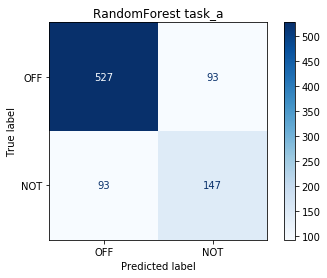

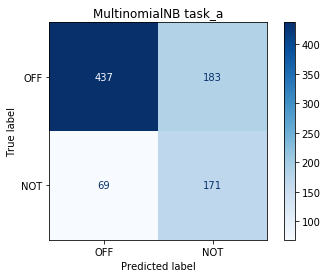

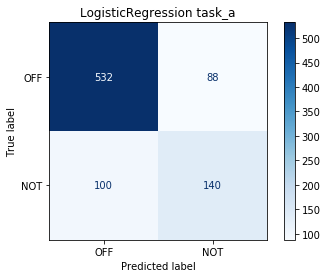

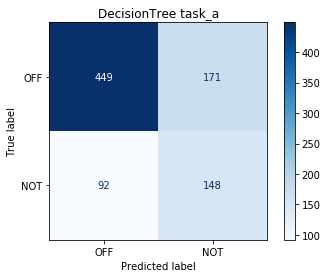

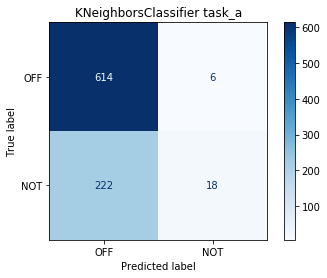

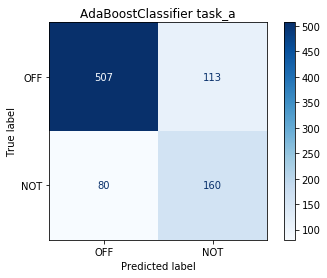

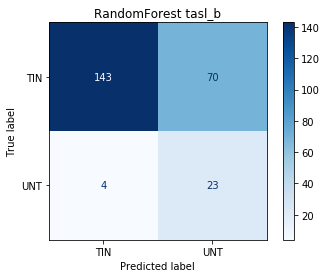

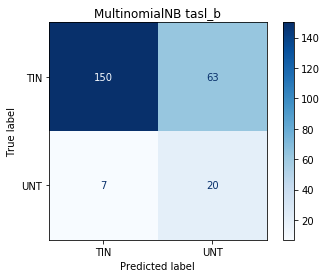

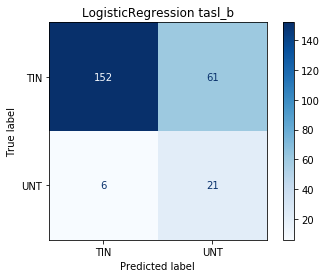

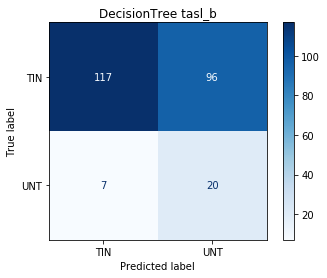

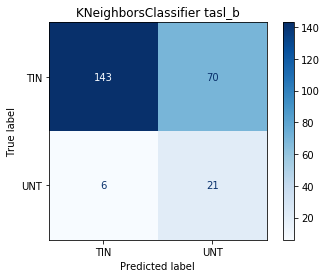

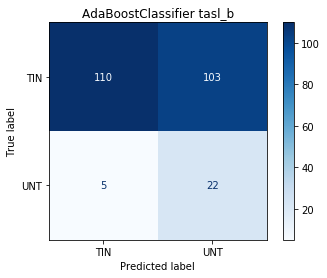

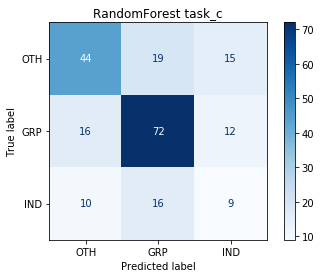

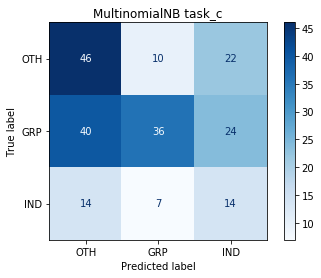

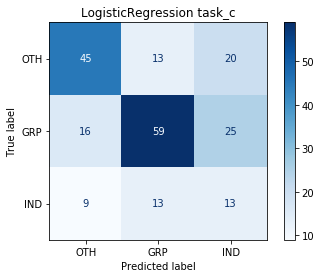

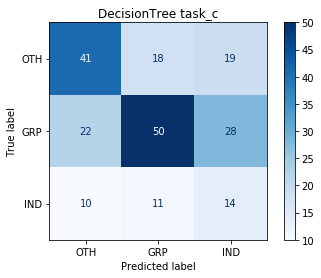

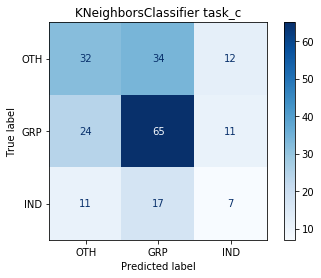

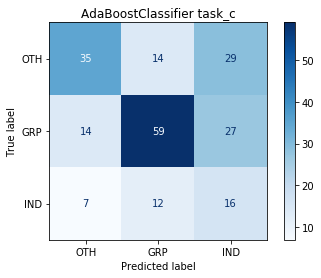

In [225]:
for x in datasetDic:
    X_train = v.transform(x[0])
    y_train = x[1]
    X_test = v.transform(pd.read_csv(x[2], sep='\t').tweet.apply(preprocess))
    y_test = pd.read_csv(x[3],index_col=0,header = None)
    print(f"--------------------------------------------------------------\n{x[4]}\n--------------------------------------------------------------")
    for clf in clfs:
        clf[0].fit(X_train, y_train)
        pred = clf[0].predict(X_test)
        print(f"--------------------------------------------------------------\n{clf[1]}\n--------------------------------------------------------------")
        print(classification_report(y_test,pred))
        plot_conf(clf[0],X_test,y_test,clf[1]+" "+x[4],clf[1]+" "+x[4])